<a href="https://colab.research.google.com/github/dfive/EHI-Project/blob/master/EHI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **Beer Data Analysis** </center>

---

# **Problem Statement**

Analyse the provided beer data and answer the following questions:

Questions:
1. Rank top 3 Breweries which produce the strongest beers?
2. Which year did beers enjoy the highest ratings?
3. Based on the user’s ratings which factors are important among taste, aroma,
appearance, and palette?
4. If you were to recommend 3 beers to your friends based on this data which ones will
you recommend?
5. Which Beer style seems to be the favorite based on Reviews written by users? How does
written review compare to overall review score for the beer style?

# 1. **Data Exploratry** 

1.1   Loading data from CSV file



In [0]:
#loading required packages
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from textblob import TextBlob


In [0]:
def dateparse (time_in_secs):  
    """
    Converting time in seconds to datetime
    Parameters: 
    time_in_secs (int): time in seconds
  
    Returns: 
    datetime: converted datetime object
    """  

    return datetime.datetime.fromtimestamp(float(time_in_secs))

#colums to be considered from CSV file
cols_names = ['beer_ABV','beer_beerId','beer_brewerId','beer_name','beer_style','review_appearance','review_palette','review_overall','review_taste','review_profileName','review_aroma','review_text','review_time']

#loading CSV file in to beer_data dataframe
beer_data=pd.read_csv('/content/drive/My Drive/Colab Notebooks/BeerDataScienceProject.csv',sep=',', names= cols_names, encoding='latin-1',header=0,date_parser=dateparse,parse_dates=['review_time'])

1.2.   Checking out type of data, summary statistics and reformatting the columns.



In [0]:
#checking the first few rows of DataFrame
beer_data.head()

In [0]:
#reordering the DataFrame columns
beer_data=beer_data[['beer_ABV','beer_beerId','beer_brewerId','beer_name','beer_style','review_appearance','review_palette','review_overall','review_taste','review_aroma','review_profileName','review_text','review_time']]

#renaming the DataFrame columns
beer_data.columns=['beer_ABV','beer_beerId','beer_brewerId','beer_name','beer_style','rating_appearance','rating_palette','rating_overall','rating_taste','rating_aroma','review_profileName','review_text','review_time']

#checking out the nformation about DataFrame including the index dtype and column dtypes, non-null values and memory usage
beer_data.info()

Well, all the columns are in required data types and few missing values for some columns. There are total 528870 rows and 12 Columns in DataFrame.

1.3 Analysing descriptive statistics for beer data





In [0]:
#generate descriptive statistics
beer_data.describe()

,beer_ABV,beer_beerId,beer_brewerId,rating_appearance,rating_palette,rating_overall,rating_taste,rating_aroma
count,508590.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000
mean,7.017442,22098.466016,2598.423429,3.864522,3.758926,3.833197,3.765993,3.817350
std,2.204460,22158.284352,5281.805350,0.604010,0.685335,0.709962,0.669018,0.718903
min,0.010000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,5.300000,1745.000000,132.000000,3.500000,3.500000,3.500000,3.500000,3.500000
50%,6.500000,14368.000000,394.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,8.500000,40528.000000,1475.000000,4.000000,4.000000,4.500000,4.000000,4.500000
max,57.700000,77310.000000,27980.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Following are findings from descriptive statistics:

*   On average beers are having 7% alchohal level but there are few beers with very high alchohal content (57.7%).
*   Average beers ratings is ranging from 3.7 to 3.9.


Lets further explore the data to get more insights on brewers, beers and beer styles.

In [0]:
#Checking count of breweries
beer_data['beer_brewerId'].value_counts()

35       39444
140      28751
132      24083
1199     20004
3818     15868
         ...  
10288        1
15194        1
9264         1
13030        1
20634        1
Name: beer_brewerId, Length: 1803, dtype: int64

Breweries with beer_brewerId 35, 140 and 132 are most reviewed Breweries.

In [0]:
#generating beer counts
beer_data['beer_name'].value_counts()

Sierra Nevada Celebration Ale                 3000
Sierra Nevada Pale Ale                        2587
Founders Breakfast Stout                      2502
Sierra Nevada Bigfoot Barleywine Style Ale    2492
La Fin Du Monde                               2483
                                              ... 
Submission                                       1
Dry Humpkin                                      1
Max Belgian Pale                                 1
The Lab Amber                                    1
Raspberry Pale Ale                               1
Name: beer_name, Length: 18339, dtype: int64

**Sierra Nevada Celebration Ale** , **Sierra Nevada Pale Ale** and **Founders Breakfast Stout** are most reviewed beers.

In [0]:
#generating beer style count
beer_data['beer_style'].value_counts()

American IPA                        43369
American Double / Imperial IPA      26106
American Double / Imperial Stout    23354
American Pale Ale (APA)             20520
American Amber / Red Ale            18731
                                    ...  
Sahti                                 139
Kvass                                 118
Gose                                   90
Happoshu                               55
Faro                                   53
Name: beer_style, Length: 104, dtype: int64

**American IPA**, **American Double / Imperial IPA**  and **American Double / Imperial Stout** are most reviewed beer styles.

In [0]:
beer_data['review_profileName'].value_counts()

northyorksammy    1858
mikesgroove       1403
BuckeyeNation     1298
womencantsail     1238
Phyl21ca          1164
                  ... 
phnphilly            1
yermomma             1
SeaBrew40            1
badworthing          1
nkronma              1
Name: review_profileName, Length: 22800, dtype: int64

**northyorksammy**, **mikesgroove** and **BuckeyeNation** are among top reviewers.

In [0]:
#lets check out the missing values
beer_data.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
rating_appearance         0
rating_palette            0
rating_overall            0
rating_taste              0
rating_aroma              0
review_profileName      115
review_text             119
review_time               0
dtype: int64

There are 20280 missing values for beer_ABV, 115 missing values for profile name and 119 missing values for review_text.

Lets impute the missing values for beer_ABV

In [0]:
#imputing beer ABV missing values with the median median beer_ABV value of beers.
beer_data["beer_ABV"] = beer_data[['beer_beerId','beer_ABV']].groupby("beer_beerId").transform(lambda x: x.fillna(x.median()))

#imputing remaing beer_ABV missing values with median beer_ABV value of brewers.
beer_data["beer_ABV"] = beer_data[['beer_brewerId','beer_ABV']].groupby("beer_brewerId").transform(lambda x: x.fillna(x.median()))

#imputing remainng beer_ABV missing value with median of overall beer_ABV value
beer_data["beer_ABV"] = beer_data['beer_ABV'].transform(lambda x: x.fillna(x.median()))

#Confirming the beer_ABV missing value imputation
beer_data.isna().sum()

beer_ABV                0
beer_beerId             0
beer_brewerId           0
beer_name               0
beer_style              0
rating_appearance       0
rating_palette          0
rating_overall          0
rating_taste            0
rating_aroma            0
review_profileName    115
review_text           119
review_time             0
dtype: int64

Well, Now lets address the questions.

# **Q1. Rank top 3 Breweries which produce the strongest beers?**

In [0]:
#Finding Rank of top 3 Breweries which produce the strongest beers on average
beer_data[['beer_brewerId','beer_ABV']].groupby(['beer_brewerId']).mean().sort_values(['beer_ABV'],ascending=False).head(3)

,beer_ABV
beer_brewerId,
6513,19.228824
736,13.763158
24215,12.466667


**Breweries with beer_brewerId 6513, 736 and 24215 are producing the strong beers with average beer_ABV of 19.23%, 13.76% and 12.47% respectivily.**

In [0]:
#Top 3 Breweries which producing beers with high ABV value
beer_data[['beer_brewerId','beer_name','beer_style','beer_ABV']].groupby(['beer_brewerId']).max().sort_values(['beer_ABV'],ascending=False).head(3)

,beer_name,beer_style,beer_ABV
beer_brewerId,,,
6513,Schorschbräu Schorschbock 57%,Weizenbock,57.7
35,WTF,Witbier,27.0
16866,White Zin,Witbier,19.5


Again brewer with brewerid **6513** is on top with producing strongest beer **Schorschbräu Schorschbock 57%**	of beer style **Weizenbock** with beer ABV content of **57.7%**.

# **Q2. Which year did beers enjoy the highest ratings?**

In [0]:
#Selecting rating columns
ratings_columns=['rating_overall','rating_aroma','rating_taste','rating_appearance','rating_palette']

#Finding the year with highest average rating
beer_data[ratings_columns].groupby([beer_data.review_time.dt.year]).agg('mean').sort_values(ratings_columns,ascending=False).head(1)

,rating_overall,rating_aroma,rating_taste,rating_appearance,rating_palette
review_time,,,,,
2000,4.181818,4.19697,3.984848,3.909091,3.939394


**Year 2000 enjoyed the highest rating on average.**

Lets further explore the year wise ratings

In [0]:
#Rating columns with reviewers
ratings_columns_with_profile=['rating_overall','rating_aroma','rating_taste','rating_appearance','rating_palette','review_profileName']

In [0]:
beer_data_rating=beer_data[ratings_columns_with_profile].groupby([beer_data.review_time.dt.year]).agg({'rating_overall': 'mean',
                                'rating_aroma': 'mean',
                                'rating_taste': 'mean',
                                'rating_palette': 'mean',     
                                'rating_appearance': 'mean',
                                'review_profileName': 'count'})

beer_data_rating_reindexed = pd.DataFrame(beer_data_rating.reset_index())

beer_data_rating_sorted = beer_data_rating_reindexed.sort_values(['review_profileName','rating_overall', 'rating_aroma','rating_taste','rating_palette','rating_appearance'], ascending=[False,False,False, False, False, False])

beer_data_rating_sorted.head(3)

,review_time,rating_overall,rating_aroma,rating_taste,rating_palette,rating_appearance,review_profileName
13,2011,3.828093,3.827497,3.786184,3.790176,3.891231,110836
12,2010,3.866139,3.849259,3.808075,3.798502,3.897788,93810
11,2009,3.864390,3.849518,3.799660,3.791261,3.893453,83534


In year 2011, beers recieved highest number of reviews/ratings.

# **Q3. Based on the user’s ratings which factors are important among taste,aroma, appearance, and palette?**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


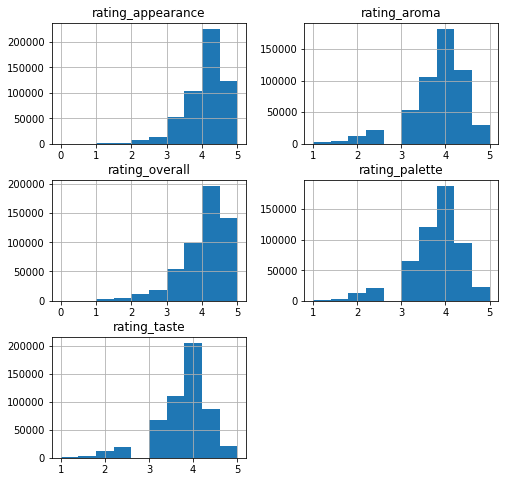

In [0]:
#Checking out distributio of different rating

fig = plt.figure(figsize = (8,8))
ax = fig.gca()
beer_data[ratings_columns].hist(ax=ax)
plt.show()

All ratings are left skewed with mean value near 4.

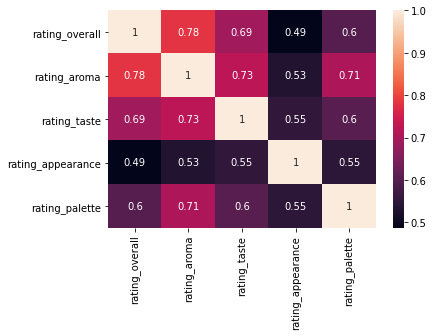

In [0]:
corr = beer_data[ratings_columns].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)
plt.show()

From correlation heatmap, we can find out that all ratings are positively correlated to each others. rating_overall is having high correlation with rating_aroma.

Lets find out important factors for overall rating.



Q3.1 Lets find out important factors by linear regression.

In [0]:
#Initializing Linear Regression model
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 1)
#Transforming data using RFE
X_rfe = rfe.fit_transform(beer_data[['rating_appearance','rating_palette','rating_taste','rating_aroma']], beer_data[ratings_columns].rating_overall)  
#Fitting the data to model
model.fit(X_rfe,beer_data.rating_overall)
print(rfe.ranking_)

[4 3 2 1]


According to Linear Regression model, important factors are in following order rating_aroma > rating_taste > rating_palette > rating_appearance.

Lets cross verify above result with Random Forest

In [0]:
#feautred columns
features_columns=['rating_appearance','rating_palette','rating_taste','rating_aroma']

In [0]:
#Lets select best param for Random forest

# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Create the hyperparameter grid
param_dist = {"max_depth": [3,5,10,15],
              "n_estimators": [10,25,50,100],
              "bootstrap": [True, False]}

# Call RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=101), param_dist)

# Fit the model
random_search.fit(beer_data[features_columns], beer_data.rating_overall)

# Print best parameters
print(random_search.best_params_)


In [0]:
#Initialize randon forest
regr = RandomForestRegressor(n_estimators= 100, max_depth= 10, bootstrap= True, random_state=101)

#Fit the model with data
regr.fit(beer_data[features_columns], beer_data.rating_overall)

importances = regr.feature_importances_
print(importances)

[0.00653008 0.00536153 0.05495505 0.93315334]


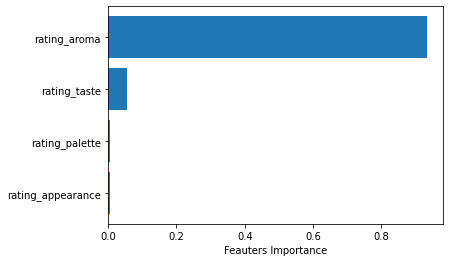

In [0]:
plt.barh(range(4), importances, tick_label=features_columns)
plt.xlabel('Feauters Importance')
plt.show()

With above graph, We can conclude that following is the order of important ratings among taste,aroma, appearance, and palette.

1. Aroma.
2. Taste.
3. Palette.
4. Appearance.

# **Q4. If you were to recommend 3 beers to your friends based on this data which ones will you recommend?**

Q4.1 Lets determine the user's sentiment from review text

*Q4.1.1 Text preprocessing for sentiment analysis*

In [0]:
import itertools
import emoji
import re

# emoticons
def load_dict_smileys():
    """
    Converting emojis to word representation
    Parameters: 
    None
  
    Returns: 
    dictonary of emoji to work mapping
    """ 
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }

# self defined contractions
def load_dict_contractions():
    """
    Loading contradictions
    Parameters: 
    None
  
    Returns: 
    dictionary of contradiction
    """ 
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }


def review_cleaning_for_sentiment_analysis(review):    
    """
    Preprocessing review
    Parameters: 
    review (str): text/review to be cleaned
  
    Returns: 
    review: processed review
    """ 
    #checking the review null and string type
    if not review:
        return None
    if not isinstance(review, str):
        return None

    
    #Special case not handled previously.
    review = review.replace('\x92',"'")
    
    
    #Removal of address
    review = ' '.join(re.sub("(\w+:\/\/\S+)", " ", review).split())
    
    #Removal of Punctuation
    review = ' '.join(re.sub("[\:\;\-\=\<\>]", " ", review).split())
    
    #Removal of hastags/account
    review = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", review).split())
    
    #Lower case
    review = review.lower()
    
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    review = review.replace("’","'")
    words = review.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    review = " ".join(reformed)
    
    # Standardizing words
    review = ''.join(''.join(s)[:2] for _, s in itertools.groupby(review))
    
    #Deal with emoticons source: https://en.wikipedia.org/wiki/List_of_emoticons
    SMILEY = load_dict_smileys()  
    words = review.split()
    reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    review = " ".join(reformed)
    
    #Deal with emojis
    review = emoji.demojize(review)

    review = review.replace(":"," ")
    review = ' '.join(review.split())

    return review

beer_data['processed_review_text']=beer_data.review_text.map(review_cleaning_for_sentiment_analysis)
beer_data.to_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_beer_data.csv')

*Q.4.1.2 Calculate Sentiment from processed_review_text*

We are using library TextBlob

In [0]:
beer_data_processed=pd.read_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_beer_data.csv')

In [0]:
beer_data_processed.info()

In [0]:
def sentiment_score_textblob(review): 
    if not review:
        return 0
    if isinstance(review, str):
        return TextBlob(review).sentiment[0]
    else:
        return 0

In [0]:
beer_data_processed['sentiment_score_textblob']=beer_data_processed.processed_review_text.map(sentiment_score_textblob)
beer_data_processed.to_csv('/content/drive/My Drive/Colab Notebooks/text_blob_sentiment_beer_data.csv')

Due to time limitation i am using simple sentiment analysis on overall reveiew text. More robust and **Aspect level sentiment analysis** can be implemented with advance libraries.

I have used flair library which is **Contextual String Embeddings techniques** to get much **higher accuracy**. But due to time and computation limitation, i could not run on all the reviews. Please find the code below for the same.

In [0]:
import flair

flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

def sentiment_score_flair(review): 
    if not review:
        return 0
    if isinstance(review, str):
        sentence = flair.data.Sentence(review)
        flair_sentiment.predict(sentence)
        if sentence.labels[0].value == "NEGATIVE":
            return -1 * sentence.labels[0].score
        else:
            return sentence.labels[0].score
    else:
        return 0

beer_data_processed['sentiment_score_flair']=beer_data_processed.processed_review_text.map(sentiment_score_flair)
beer_data_processed.to_csv('/content/drive/My Drive/Colab Notebooks/flair_sentiment_beer_data.csv')

In [0]:
beer_data_with_sentiment=pd.read_csv('/content/drive/My Drive/Colab Notebooks/text_blob_sentiment_beer_data.csv')

In [0]:
recommend_features=['beer_beerId','rating_overall','rating_appearance','rating_palette','rating_taste','rating_aroma','sentiment_score_textblob','beer_ABV','review_profileName']
beer_data_recommend=beer_data_with_sentiment[recommend_features]

In [0]:
recommend_df = beer_data_recommend.groupby('beer_beerId').agg({'rating_overall': 'mean',
                                'rating_aroma': 'mean',
                                'rating_taste': 'mean',
                                'rating_palette': 'mean',     
                                'rating_appearance': 'mean',
                                'sentiment_score_textblob': 'mean',
                                'review_profileName': 'count'})

recommend_df_reindexed = pd.DataFrame(recommend_df.reset_index())

recommend_df_sorted = recommend_df_reindexed.sort_values(['review_profileName','rating_overall','sentiment_score_textblob', 'rating_aroma','rating_taste','rating_palette','rating_appearance'], ascending=[False,False,False, False, False, False, False])


In [0]:
recommend_df_sorted.head(10)

,beer_beerId,rating_overall,rating_aroma,rating_taste,rating_palette,rating_appearance,sentiment_score_textblob,review_profileName
468,1904,4.168667,4.190000,4.076000,4.082333,4.225167,0.231990,2999
74,276,4.245845,4.115385,3.966950,3.915539,3.995168,0.234444,2587
3003,11757,4.354516,4.501199,4.387890,4.412070,4.364508,0.180985,2501
657,2671,3.966091,4.189005,4.126204,4.155698,4.258628,0.191054,2491
15,34,4.298027,4.396093,4.264398,4.231977,4.193919,0.228164,2483
23,104,4.044251,3.872415,3.774194,3.663358,3.886476,0.252166,2417
81,355,4.044987,4.023053,3.912936,3.800806,3.892122,0.218889,2232
157,645,4.339401,4.543548,4.430876,4.418664,4.344931,0.191297,2170
7586,30420,4.104485,4.113849,4.029571,4.019961,4.170527,0.221705,2029
137,571,4.240741,4.266667,4.200247,4.018272,4.250864,0.203093,2024


In [0]:
beer_data_processed['beer_name'].loc[beer_data_processed['beer_beerId'].isin([1904,276,34])].unique()

array(['Sierra Nevada Celebration Ale', 'Sierra Nevada Pale Ale',
       'La Fin Du Monde'], dtype=object)

**Based on above popular ten beers, I will recommend Sierra Nevada Celebration Ale, Sierra Nevada Pale Ale and La Fin Du Monde.  These beeers are widely enjoyed by users with good rating and positive sentiment. **

Due to time limitation, I am using this simple approach to answer the question. More robust solution can be implemented with **multi criteria recommendation system**.

# **Q5. Which Beer style seems to be the favorite based on Reviews written by users? How does written review compare to overall review score for the beer style?**

In [0]:
beer_data_with_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                528870 non-null  int64  
 1   Unnamed: 0.1              528870 non-null  int64  
 2   beer_ABV                  528870 non-null  float64
 3   beer_beerId               528870 non-null  int64  
 4   beer_brewerId             528870 non-null  int64  
 5   beer_name                 528870 non-null  object 
 6   beer_style                528870 non-null  object 
 7   rating_appearance         528870 non-null  float64
 8   rating_palette            528870 non-null  float64
 9   rating_overall            528870 non-null  float64
 10  rating_taste              528870 non-null  float64
 11  rating_aroma              528870 non-null  float64
 12  review_profileName        528755 non-null  object 
 13  review_text               528751 non-null  o

In [0]:
beer_data_with_sentiment[['beer_style','sentiment_score_textblob']].groupby(['beer_style']).mean().sort_values(['sentiment_score_textblob'],ascending=False).head()

,sentiment_score_textblob
beer_style,
Dortmunder / Export Lager,0.234047
Vienna Lager,0.231024
Czech Pilsener,0.210332
American IPA,0.209473
Rye Beer,0.206520


In [0]:
fav_beer_style_df = beer_data_with_sentiment[['beer_style','sentiment_score_textblob','review_profileName']].groupby('beer_style').agg({
                                'sentiment_score_textblob': 'mean',
                                'review_profileName': 'count'})

fav_beer_style_df_reindexed = pd.DataFrame(fav_beer_style_df.reset_index())

fav_beer_style_df_sorted = fav_beer_style_df_reindexed.sort_values(['sentiment_score_textblob','review_profileName'], ascending=[False,False])
fav_beer_style_df_sorted.head()

,beer_style,sentiment_score_textblob,review_profileName
38,Dortmunder / Export Lager,0.234047,1809
99,Vienna Lager,0.231024,4607
36,Czech Pilsener,0.210332,5845
12,American IPA,0.209473,43363
90,Rye Beer,0.206520,5178


Beer Style **Dortmunder / Export Lager** is favorite based on reviews written by users.

In [0]:
beer_data_with_sentiment[['rating_overall','sentiment_score_textblob']].corr()

Overall rating is positively correlated with the written review sentiment.